In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
matplotlib.rcParams['animation.embed_limit'] = 2**128
import scipy.interpolate as interpolate
import seaborn as sns
import datetime as dt
from IPython.display import HTML
import os
plt.rcParams['animation.ffmpeg_path'] = '../ffmpeg.exe'

In [2]:
class Params():
    def __init__(self):
        self.pop_size = 2500
        self.age_mean = 46
        self.age_std = 13
        self.age_min = 0
        self.age_max = 99
        
        self.colors = ["#59BFFF", "#FC6A03", "#E3242B", "#7C5295", "#028A0F", "#1B1E23"]
        # Minimum of 25
        self.num_of_frames = 250
        self.x_min = 0
        self.x_max = 1
        self.x_min_bound = 0.02
        self.x_max_bound = 0.98
        self.y_min = 0
        self.y_max = 1
        self.y_min_bound = 0.02
        self.y_max_bound = 0.98
        # Zone of infection (Inversely related to how many rows and columns
        # the grid is broken into when determining infection zones)
        self.infection_zone = 0.002
        # Rate of infectiousness
        self.morbidity_rate = 0.8
        # Rate at which each age group becomes symptomatic
        self.symptomatic_rate = {
            0 : 0.6,
            1 : 0.6,
            2 : 0.65,
            3 : 0.7,
            4 : 0.7,
            5 : 0.75,
            6 : 0.8,
            7 : 0.85,
            8 : 0.9,
            9 : 0.95
        }
        # Rate at which each age group dies from their symptoms
        self.mortality_rate = {
            0 : 0.05,
            1 : 0.05,
            2 : 0.01,
            3 : 0.03,
            4 : 0.05,
            5 : 0.10,
            6 : 0.12,
            7 : 0.15,
            8 : 0.18,
            9 : 0.20
        }
        self.incubation_period = 300
        self.symptomatic_period = 200
        self.infectious_after_immunity = 72
        self.hospital_capacity = 100
        
        self.save_folder = "C:/Users/ParthivNaresh/Pandemic-Simulations/Outputs/"

In [3]:
def initialize(pm):
    population = pd.DataFrame()

    population["id"] = pd.Series([x for x in range(pm.pop_size)])
    population["current_x"] = np.random.uniform(0, 1, pm.pop_size)
    population["current_x"] = np.clip(population["current_x"], pm.x_min_bound, pm.x_max_bound)
    population["current_y"] = np.random.uniform(0, 1, pm.pop_size)
    population["current_y"] = np.clip(population["current_y"], pm.y_min_bound, pm.y_max_bound)
    population["age"] = np.random.normal(pm.age_mean, pm.age_std, size = pm.pop_size)
    population["age"] = np.clip(round(population["age"]), pm.age_min, pm.age_max)
    population["age"] = population["age"].astype(int)
    # 0 for healthy, 1 for infected-asymptomatic, 2 for infected-symptomatic,
    # 3 for immune-infectious, 4 for immune-noninfectious, 5 for dead 
    population["state"] = pd.Series(0 for x in range(pm.pop_size))
    population["state_color"] = [pm.colors[each] for each in population["state"]]
    population["frames_since_infected"] = pd.Series(0 for x in range(pm.pop_size))
    population["frames_since_symptomatic"] = pd.Series(0 for x in range(pm.pop_size))
    population["frames_since_immune"] = pd.Series(0 for x in range(pm.pop_size))
    population["first_destiny"] = pd.Series(0 for x in range(pm.pop_size))
    population["second_destiny"] = pd.Series(0 for x in range(pm.pop_size))

    #data.insert(data.columns.get_loc("state"), "Age", np.random.normal(size=2000), True)
    
    return population


In [4]:
# Returns a 100 x 100 numpy array with a "human_state" (usually 1 for infected)
# for every grid that contains a person in that state and in every grid adjacent.
def identify_matrix(population, params, human_state):
    size = int(1/params.infection_zone)
    matrix = [[0 for each in range(size)] for each in range(size)]
    matrix = np.array(matrix)
    sick_people = population[population["state"]==human_state]
    sick_people_size = len(sick_people)
    sick = np.hstack(( sick_people["id"].values.reshape(sick_people_size,1),
                             (np.hstack(( sick_people["current_x"].values
                                         .reshape(sick_people_size,1),
                                         sick_people["current_y"].values
                                         .reshape(sick_people_size,1) )) * size).astype(int)))
    matrix[len(matrix)-1-sick[:,2], sick[:,1]] = human_state
    matrix[len(matrix)-sick[:,2], sick[:,1]] = human_state
    matrix[len(matrix)-2-sick[:,2], sick[:,1]] = human_state
    matrix[len(matrix)-1-sick[:,2], sick[:,1]-1] = human_state
    matrix[len(matrix)-1-sick[:,2], sick[:,1]+1] = human_state
    matrix[len(matrix)-sick[:,2], sick[:,1]-1] = human_state
    matrix[len(matrix)-sick[:,2], sick[:,1]+1] = human_state
    matrix[len(matrix)-2-sick[:,2], sick[:,1]-1] = human_state
    matrix[len(matrix)-2-sick[:,2], sick[:,1]+1] = human_state
    return matrix

In [5]:
# Returns a list of people of "people_state" sharing the same location in the grid
# marked with "matrix_state".
# e.g. return all the healthy people within infected zones
# people_within_matrix(population, infection_matrix, 0, 1)
def people_within_matrix(population, params, matrix, people_state, matrix_state):
    size = int(1/params.infection_zone)
    people_in_zone = []
    healthy_people = population[population["state"]==people_state]
    healthy_people_size = len(healthy_people)
    healthy = np.hstack(( healthy_people["id"].values.reshape(healthy_people_size,1),
                         (np.hstack(( healthy_people["current_x"].values
                                     .reshape(healthy_people_size,1),
                                     healthy_people["current_y"].values
                                     .reshape(healthy_people_size,1) )) * size).astype(int)))
    spot_state = np.array([[my_id,matrix[len(matrix)-1-y][x]] for my_id,y,x in zip(healthy[:,0],healthy[:,2],healthy[:,1])])
    try:
        people_in_zone = spot_state[spot_state[:,1]==matrix_state][:,0]
    except:
        print("__________FAILURE_________")
        print(healthy_people, healthy_people_size, spot_state)
    return people_in_zone

In [6]:
# Rolls the dice on infecting healthy people surrounding an infected
# person (aymptomatic or symptomatic) or an immune person (infectious).
def infect(population, params, infected_from_state):
    start_time = dt.datetime.now()
    infection_matrix = identify_matrix(population, params, infected_from_state)
    infect_time = dt.datetime.now()
    total_infect = ((infect_time-start_time)*1000).total_seconds()
    #print(f'Infect time {total_infect}')
    exposed_people = people_within_matrix(population, params, infection_matrix, 0, infected_from_state)
    people_time = dt.datetime.now()
    total_people = ((people_time-infect_time)*1000).total_seconds()
    #print(f'People time {total_people}')
    #print(f'Exposed people calculated in {total_people}ms')
    # Roll the dice on whether a person will get sick based on the morbidity rate.
    for exposed_person in exposed_people:
        if (np.random.random() < params.morbidity_rate):
                population.at[exposed_person, "state"] = 1
                population.at[exposed_person, "state_color"] = params.colors[1]
    
    return population
#pm = Params()
#pop = initialize(pm)
#infection_matrix(pop, pm)

In [7]:
def incubation_determination(population, params):
    # Assign an initial destiny of infected-symptomatic or immune-uninfectious
    # to everyone who has been infected-asymptomatic for at least one frame.
    population = assign_destiny(population, params)
    # Symptomize anyone asymptomatic who is destined to become symptomatic
    population = symptomize(population, params)
    # Immunize anyone asymptomatic who has lasted the incubation period
    population = immunize(population, params)
    # Kill anyone symptomatic who is destined to die
    population = kill(population, params)
    
    return population

In [8]:
def assign_destiny(population, params):
    # Population of newly infected-asymptomatic people
    new_infected = population[(population.frames_since_infected==1) & 
                          (population.state==1)]
    # A series of probabilities determining whether a person will be symptomatic
    # within the incubation period based on their age.
    symp_rate_by_age = ((new_infected["age"]/10).astype(int)).apply(lambda age: params.symptomatic_rate.get(age))
    # All newly infected people are iterated over and assigned a destiny based on
    # their likelihood of becoming symptomatic.
    for ind, rate in zip(symp_rate_by_age.index.values, symp_rate_by_age):
        if (np.random.random() <= rate):
            population.at[ind, "first_destiny"] = 2
        else:
            population.at[ind, "first_destiny"] = 3
    
    new_symptomatic = population[(population.frames_since_symptomatic==1) & 
                          (population.state==2)]
    death_rate_by_age = ((new_symptomatic["age"]/10).astype(int)).apply(lambda age: params.mortality_rate.get(age))
    # All newly symptomatic people are iterated over and assigned a destiny based on
    # their likelihood of dying.
    for ind, rate in zip(death_rate_by_age.index.values, death_rate_by_age):
        if (np.random.random() <= rate):
            population.at[ind, "second_destiny"] = 5
        else:
            population.at[ind, "second_destiny"] = 3
    return population

In [9]:
def symptomize(population, params):
    # Population of infected-asymptomatic people destined to be symptomatic who are
    # still within the incubation period.
    infected_asymp_early = population[(population.frames_since_infected<params.incubation_period) & 
                          (population.state==1) & (population.first_destiny==2)]
    # A sample of this population equal to the inverse of the incubation period is
    # iterated over every frame and made symptomatic.
    for ind, person_to_symp in infected_asymp_early.sample(frac=(1/2)).iterrows():
        population.at[ind, "state"] = 2
        population.at[ind, "state_color"] = params.colors[2]
    # Population of infected-asymptomatic people destined to be symptomatic who are
    # on the last day of the incubation period.
    infected_asymp_final = population[(population.frames_since_infected==params.incubation_period) & 
                          (population.state==1) & (population.first_destiny==2)]
    # Everyone destined to be symptomatic is made symptomatic.
    for ind, person_to_symp in infected_asymp_final.iterrows():
        population.at[ind, "state"] = 2
        population.at[ind, "state_color"] = params.colors[2]
    return population

In [10]:
def immunize(population, params):
    # Population of infected-asymptomatic people who have lasted the incubation period
    # and are destined for immunity will now become immune-infectious.
    immune_and_infectious = population[(population.frames_since_infected>params.incubation_period) & 
                          (population.state==1) & (population.first_destiny==3)]
    # Everyone destined to be immune is made immune-infectious.
    for ind, immune_person in immune_and_infectious.iterrows():
        population.at[ind, "state"] = 3
        population.at[ind, "state_color"] = params.colors[3]
    # A sample of this population equal to the inverse of the symptomatic period is
    # iterated over every frame and made immune-infectious.
    immune_and_infectious_early = population[(population.frames_since_symptomatic<params.symptomatic_period) & 
                          (population.state==2) & (population.second_destiny==3)]
    for ind, immune_person in immune_and_infectious_early.sample(frac=(1/params.symptomatic_period)).iterrows():
        population.at[ind, "state"] = 3
        population.at[ind, "state_color"] = params.colors[3]
    # Population of infectious-symptomatic people who are destined to be immune-infectious
    # on the last day of the symptomatic period. 
    immune_and_infectious_final = population[(population.frames_since_symptomatic==params.symptomatic_period) & 
                          (population.state==2) & (population.second_destiny==3)]
    for ind, immune_person in immune_and_infectious_final.iterrows():
        population.at[ind, "state"] = 3
        population.at[ind, "state_color"] = params.colors[3]
    # Everyone immune-infectious is made immune-uninfectious after 3 frames.
    immune_and_uninfectious = population[(population.frames_since_immune>params.infectious_after_immunity) & 
                          (population.state==3)]
    for ind, immune_person in immune_and_uninfectious.iterrows():
        population.at[ind, "state"] = 4
        population.at[ind, "state_color"] = params.colors[4]
    return population
    

In [11]:
def kill(population, params):
    dead_early = population[(population.frames_since_symptomatic<params.symptomatic_period) & 
                          (population.state==2) & (population.second_destiny==5)]
    # A sample of this population equal to the inverse of the incubation period is
    # iterated over every frame and made symptomatic.
    for ind, dead_person in dead_early.sample(frac=(1/5)).iterrows():
        population.at[ind, "state"] = 5
        population.at[ind, "state_color"] = params.colors[5]
    
    dead_final = population[(population.frames_since_symptomatic==params.symptomatic_period) & 
                          (population.state==2) & (population.second_destiny==5)]
    for ind, dead_person in dead_final.iterrows():
        population.at[ind, "state"] = 5
        population.at[ind, "state_color"] = params.colors[5]
    
    return population

In [12]:
class Simulation():
    
    def __init__(self, *args, **kwargs):
        self.initialize_parameters()
        self.initialize_population()
        self.initialize_movementstream()
        
        self.begin_simulation = dt.datetime.now()
        self.startframe_25 = dt.datetime.now()
        
        self.time_iteration = 0
        self.time_incubation = 0
        self.time_infect = 0
        self.time_move = 0
        self.checkpoint_25 = 0
        
        self.simulation_tensor = {}
        
        for frame in range(self.params.num_of_frames):
            self.next_frame(frame)
        
    def initialize_parameters(self):
        self.params = Params()
    
    def initialize_population(self):
        self.population = initialize(self.params)
        
    def initialize_movementstream(self):
        self.stream = self.movement_stream()
        
    def movement_stream(self):
        while True:
            x_delta = np.array([0.004 for pop in range(self.params.pop_size)]).reshape(self.params.pop_size, 1)
            x_delta[:int(len(x_delta)/2)] = -1 * x_delta[:int(len(x_delta)/2)]
            np.random.shuffle(x_delta)
            x_delta[:int(len(x_delta)/2)] = 0
            np.random.shuffle(x_delta)
            y_delta = np.array([0.004 for pop in range(self.params.pop_size)]).reshape(self.params.pop_size, 1)
            y_delta[:int(len(y_delta)/2)] = -1 * y_delta[:int(len(y_delta)/2)]
            np.random.shuffle(y_delta)
            y_delta[:int(len(y_delta)/2)] = 0
            np.random.shuffle(y_delta)
            xy_delta = np.hstack([x_delta, y_delta])
            list_of_the_dead = self.population.loc[self.population["state"]==5].index.values
            xy_delta[list_of_the_dead] = [0,0]
            yield xy_delta
    
    def take_step(self, i):
        if (i % 5 == 0):
            #print(f'Frame {i} speed')
            self.xy_delta = next(self.stream)
        # Increment the current position
        xy_pos = np.hstack([np.array(self.population["current_x"]).reshape(self.params.pop_size,1), 
                            np.array(self.population["current_y"]).reshape(self.params.pop_size,1)])
        xy_new_pos = xy_pos + self.xy_delta
        # Keep the positions of the population within the x and y bounds
        xy_new_pos[:, 0] = np.clip(xy_new_pos[:, 0], self.params.x_min_bound, self.params.x_max_bound)
        xy_new_pos[:, 1] = np.clip(xy_new_pos[:, 1], self.params.y_min_bound, self.params.y_max_bound)
        # Update the positions within the dataframe
        self.population["current_x"] = np.clip(xy_new_pos[:, 0], self.params.x_min_bound, self.params.x_max_bound)
        self.population["current_y"] = np.clip(xy_new_pos[:, 1], self.params.y_min_bound, self.params.y_max_bound)
        
        return xy_new_pos
    
    def next_frame(self, i):
        begin_frame = dt.datetime.now()
        
        self.population.loc[self.population["state"]==1, ["frames_since_infected"]] += 1
        self.population.loc[self.population["state"]==2, ["frames_since_symptomatic"]] += 1
        self.population.loc[self.population["state"]==3, ["frames_since_immune"]] += 1
        end_iteration = dt.datetime.now()
        
        # Determine outcomes during the incubation period
        self.population = incubation_determination(self.population, self.params)
        end_incubation = dt.datetime.now()
        
        # Infect someone at frame 1
        if (i == 1):
            self.population.at[i, "state"] = 1
            self.population.at[i, "state_color"] = self.params.colors[1]
        # Infect new people
        
        for each_state in [1, 2, 3]:
            if not (len(self.population[self.population["state"]==0])==0):
                self.population = infect(self.population, self.params, each_state)
            else:
                break
        end_infect = dt.datetime.now()
        
        # Move the population
        self.new_pos = self.take_step(i)
        end_move = dt.datetime.now()
        
        self.monitor_execution(i, begin_frame, end_iteration, end_incubation, end_infect, end_move)
        
        self.simulation_tensor[i] = self.population[["current_x", "current_y", "state", "state_color"]]
    
    def monitor_execution(self, i, begin_frame, end_iteration, end_incubation, end_infect, end_move):
        self.time_iteration += ((end_iteration - begin_frame)*1000).total_seconds()
        self.time_incubation += ((end_incubation - end_iteration)*1000).total_seconds()
        self.time_infect += ((end_infect - end_incubation)*1000).total_seconds()
        self.time_move += ((end_move - end_infect)*1000).total_seconds()
        # Keep track of the speed of execution every 25 frames
        if (i >= 25 and i % 25 == 0):
            self.endframe_25 = dt.datetime.now()
            self.checkpoint_25 += ((self.endframe_25 - self.startframe_25)*1000).total_seconds()
            print('______________________________________')
            print(f'Iteration time: {self.time_iteration}ms')
            print(f'Incubation time: {self.time_incubation}ms')
            print(f'Infect time: {self.time_infect}ms')
            print(f'Move time: {self.time_move}ms')
            print(f'From frame {i-25} to {i} it took {self.checkpoint_25}')
            self.time_iteration = 0
            self.time_incubation = 0
            self.time_infect = 0
            self.time_move = 0
            self.checkpoint_25 = 0
            self.startframe_25 = dt.datetime.now()
        # Time taken between the last checkpoint and the final frame
        if (i == self.params.num_of_frames - 1):
            self.end_time(i)

    def end_time(self, i):
        self.end_simulation = dt.datetime.now()
        print("=============Ending Simulation=============")
        if not (i % 25 == 0):
            final_checkpoint_25 = ((self.end_simulation - self.startframe_25) * 1000).total_seconds()
            print("Last set of frames took", final_checkpoint_25)
        
        simulation_time = ((self.end_simulation - self.begin_simulation) * 1000).total_seconds()
        print(f'Total time: {simulation_time}ms')

if __name__ == '__main__':
    simulation = Simulation()

______________________________________
Iteration time: 822.2979999999999ms
Incubation time: 972.8930000000001ms
Infect time: 4400.681999999999ms
Move time: 174.995ms
From frame 0 to 25 it took 6434.727
______________________________________
Iteration time: 546.1129999999999ms
Incubation time: 630.412ms
Infect time: 3115.044ms
Move time: 123.601ms
From frame 25 to 50 it took 4456.08
______________________________________
Iteration time: 545.548ms
Incubation time: 641.9839999999999ms
Infect time: 3190.83ms
Move time: 111.88400000000001ms
From frame 50 to 75 it took 4528.886
______________________________________
Iteration time: 521.72ms
Incubation time: 680.805ms
Infect time: 3099.587ms
Move time: 107.744ms
From frame 75 to 100 it took 4445.112
______________________________________
Iteration time: 552.963ms
Incubation time: 657.7139999999999ms
Infect time: 3145.6579999999994ms
Move time: 103.39500000000001ms
From frame 100 to 125 it took 4507.94
______________________________________
It

In [13]:
print(len(simulation.simulation_tensor))

250


Total setup time took 62.831ms
______________________________________
Move time: 16.235ms
Ax2 time: 169.28300000000002ms
Ax3 time: 43.67799999999999ms
Color time: 641.8570000000001ms
From frame 0 to 25 it took 6381.299
______________________________________
Move time: 9.187000000000001ms
Ax2 time: 177.98300000000006ms
Ax3 time: 59.30899999999999ms
Color time: 660.8040000000001ms
From frame 25 to 50 it took 6203.441
______________________________________
Move time: 17.931ms
Ax2 time: 208.60300000000004ms
Ax3 time: 55.69199999999998ms
Color time: 701.3170000000002ms
From frame 50 to 75 it took 6177.014
______________________________________
Move time: 14.175999999999998ms
Ax2 time: 166.40599999999995ms
Ax3 time: 60.351000000000006ms
Color time: 608.3609999999999ms
From frame 75 to 100 it took 5938.634
______________________________________
Move time: 20.131999999999998ms
Ax2 time: 196.21099999999998ms
Ax3 time: 60.871ms
Color time: 709.049ms
From frame 100 to 125 it took 6884.109
_______

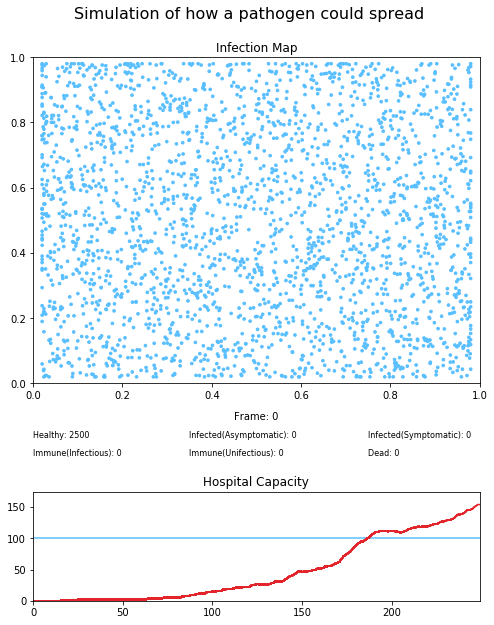

In [14]:
class Render():
    
    def __init__(self, sim_tensor):
        self.initialize_parameters()
        
        #sns.set()
        
        self.begin_render = dt.datetime.now()
        self.startframe_25 = dt.datetime.now()
        
        self.this_df = sim_tensor[0]
        
        self.begin_setup = dt.datetime.now()
        self.setup_fig()
        self.setup_ax1()
        self.setup_ax1scatter()
        self.setup_ax2()
        self.setup_ax3()
        self.end_setup = dt.datetime.now()
        self.setup_time = ((self.end_setup - self.begin_setup) * 1000).total_seconds()
        print(f'Total setup time took {self.setup_time}ms')
        
        self.time_move = 0
        self.time_ax2 = 0
        self.time_ax3 = 0
        self.time_color = 0
        self.checkpoint_25 = 0

        self.render_tensor = sim_tensor
        self.create_animation()
    
    def initialize_parameters(self):
        self.params = Params()
    
    def setup_fig(self):
        self.fig = plt.figure(figsize=(8,10))
        self.fig.suptitle('Simulation of how a pathogen could spread', y=0.95, fontsize=16)
        self.grid = plt.GridSpec(8, 6, hspace=1)
    
    def setup_ax1(self):
        self.ax1 = self.fig.add_subplot(self.grid[:5,:])
        self.ax1.set_title('Infection Map', fontdict={'fontsize':12, 'color': 'black'})
        self.ax1.set_xlim((self.params.x_min, self.params.x_max))
        self.ax1.set_ylim((self.params.y_min, self.params.y_max))

    def setup_ax1scatter(self):
        #self.scat = sns.scatterplot(x = self.this_df["current_x"], 
        #                            y = self.this_df["current_y"], ax=self.ax1)
        self.scat = self.ax1.scatter(x = self.this_df["current_x"], 
                                    y = self.this_df["current_y"], 
                                    s = 7, c = self.this_df["state_color"])
    
    def setup_ax2(self):
        self.ax2 = self.fig.add_subplot(self.grid[5:6,:])
        self.text_frames = self.ax2.text(0.45, 1, "", fontsize=10)
        self.text_healthy = self.ax2.text(0, 0.5, "", fontsize=8)
        self.text_infected_a = self.ax2.text(0.35, 0.5, "", fontsize=8)
        self.text_infected_s = self.ax2.text(0.75, 0.5, "", fontsize=8)
        self.text_immune_i = self.ax2.text(0, 0, "", fontsize=8)
        self.text_immune_u = self.ax2.text(0.35, 0, "", fontsize=8)
        self.text_dead = self.ax2.text(0.75, 0, "", fontsize=8)
        self.ax2.set_axis_off()
    
    def setup_ax3(self):
        self.ax3 = self.fig.add_subplot(self.grid[6:,:])
        self.ax3.set_title('Hospital Capacity', fontdict={'fontsize':12, 'color': 'black'})
        self.ax3.set_xlim((0, 1))
        self.ax3.set_ylim((0, 50))
        self.ax3.axhline(y=self.params.hospital_capacity, c="#59BFFF")
        self.running_frames = np.array([])
        self.running_infected = np.array([0])
        self.running_immune = []
        self.running_dead = []
    
    def create_animation(self):
        self.ani = animation.FuncAnimation(self.fig, self.next_frame, 
                                           frames = self.params.num_of_frames, 
                                           interval = 33, blit = False, save_count=100,
                                           cache_frame_data=False)
    
    def update_ax2_stats(self, frame):
        self.healthy = self.this_df[self.this_df["state"] == 0]
        self.infected_a = self.this_df[self.this_df["state"] == 1]
        self.infected_s = self.this_df[self.this_df["state"] == 2]
        self.immune_i = self.this_df[self.this_df["state"] == 3]
        self.immune_u = self.this_df[self.this_df["state"] == 4]
        self.dead = self.this_df[self.this_df["state"] == 5]
        self.text_frames.set_text(f'Frame: {frame}')
        self.text_healthy.set_text(f'Healthy: {len(self.healthy)}')
        self.text_infected_a.set_text(f'Infected(Asymptomatic): {len(self.infected_a)}')
        self.text_infected_s.set_text(f'Infected(Symptomatic): {len(self.infected_s)}')
        self.text_immune_i.set_text(f'Immune(Infectious): {len(self.immune_i)}')
        self.text_immune_u.set_text(f'Immune(Unifectious): {len(self.immune_u)}')
        self.text_dead.set_text(f'Dead: {len(self.dead)}')
        
    def update_ax3_chart(self, i):
        if (i>0):
            self.ax3.set_xlim((0, i))
            self.running_infected = np.append(self.running_infected, len(self.this_df[self.this_df["state"] == 2]))
            x_new = np.linspace(0, i, i+1)
            self.track_infected = self.ax3.plot(x_new, self.running_infected, c="#E3242B")
            self.ax3.set_ylim((0, max(self.running_infected)+20))
        
    def extract_newpos(self):
        new_pos = np.hstack([np.array(self.this_df["current_x"]).reshape(self.params.pop_size,1),
                                  np.array(self.this_df["current_y"]).reshape(self.params.pop_size,1)])
        return new_pos
    
    def next_frame(self, i):
        begin_frame = dt.datetime.now()
        self.this_df = self.render_tensor[i]
        # Move the population
        self.new_pos = self.extract_newpos()
        self.scat.set_offsets(self.new_pos)
        end_move = dt.datetime.now()
        
        # Update ax2 stats
        self.update_ax2_stats(i)
        end_ax2 = dt.datetime.now()
        # Update ax3 chart
        self.update_ax3_chart(i)
        end_ax3 = dt.datetime.now()
        
        # Set the population color to visually show the state
        self.scat.set_color(self.this_df["state_color"])
        end_color = dt.datetime.now()
        
        self.monitor_execution(i, begin_frame, end_move, end_ax2, end_ax3, end_color)
        
        return self.scat,
    
    def monitor_execution(self, i, begin_frame, end_move, end_ax2, end_ax3, end_color):
        self.time_move += ((end_move - begin_frame)*1000).total_seconds()
        self.time_ax2 += ((end_ax2 - end_move)*1000).total_seconds()
        self.time_ax3 += ((end_ax3 - end_ax2)*1000).total_seconds()
        self.time_color += ((end_color - end_ax3)*1000).total_seconds()
        # Keep track of the speed of execution every 25 frames
        if (i >= 25 and i % 25 == 0):
            self.endframe_25 = dt.datetime.now()
            self.checkpoint_25 += ((self.endframe_25 - self.startframe_25)*1000).total_seconds()
            print('______________________________________')
            print(f'Move time: {self.time_move}ms')
            print(f'Ax2 time: {self.time_ax2}ms')
            print(f'Ax3 time: {self.time_ax3}ms')
            print(f'Color time: {self.time_color}ms')
            print(f'From frame {i-25} to {i} it took {self.checkpoint_25}')
            self.time_move = 0
            self.time_ax2 = 0
            self.time_ax3 = 0
            self.time_color = 0
            self.checkpoint_25 = 0
            self.startframe_25 = dt.datetime.now()
        # Time taken between the last checkpoint and the final frame
        if (i == self.params.num_of_frames - 1):
            self.end_time(i)

    def end_time(self, i):
        self.end_render = dt.datetime.now()
        print("=============Ending Render=============")
        if not (i % 25 == 0):
            final_checkpoint_25 = ((self.end_render - self.startframe_25) * 1000).total_seconds()
            print("Last set of frames took", final_checkpoint_25)
        
        render_time = ((self.end_render - self.begin_render) * 1000).total_seconds()
        print(f'Total time, {render_time}ms')

final_render = Render(simulation.simulation_tensor)
HTML(final_render.ani.to_html5_video())

In [ ]:
HTML(final_render.ani.to_html5_video())

In [ ]:
with open("Perfect_curve_1.html", "w") as f:
    print(final_render.ani.to_html5_video(), file=f)